# Unit 3.3.2 Ridge Regression

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

# Improving on OLS

When we introduced regression, we said that the model fit is determined by minimizing the sum of the squared differences between the predicted and actual values. This is _Ordinary Least Squares_:

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2$$

It just so happens, however, that we can get more accurate *predictions* by modifying this cost function in various ways.  One way to think of this is that the OLS cost function optimizes variance explained *in the training set.*  Ridge and lasso regressions are two examples of modifying this cost function. They lead to models that optimize variance explained *in the test sets.*  Generally our goal is to make a model that tells us about the world (and not just our training sample), so ridge and lasso solutions are useful.

# Ridge regression

**Ridge regression** minimizes this cost function:

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p\beta_j^2 $$

Comparing this cost function to the OLS cost function above, you can see it consists of the OLS function with a new part to the right:

$$\lambda\sum_{j=1}^p\beta_j^2 $$

**This new part imposes a penalty for large coefficients.**  It represents the sum of the square of all model coefficients (numbered 1 through $p$), multiplied by the regularization parameter $\lambda$.  As $\lambda$ gets larger, the penalty for coefficient size also gets larger, and the solution that minimizes the cost function will by necessity have smaller coefficient estimates.  Regularization based on the sum of the squared weights is also called "**L2 regularization**".

[**Quick check**: If the convention is to call the regularization parameter "*lambda*" ($\lambda$), why does SKlearn call it "*alpha*"?  Hint: It's the same reason why you shouldn't name your own variables in Python things like "mean".]

**The core principle behind ridge regression is that, as models become increasingly complex and features correlate with one another more and more (become _multicolinear_), coefficients arrived at by OLS become increasingly large.** This is a sign that the model is incorporating too much variance from the dataset – in other words, overfitting. Ridge regression is a model variance minimizer and works to keep that from happening. For a deep dive into the underlying math and origin of the term "ridge regression" see this detailed [Stack Exchange answer](http://stats.stackexchange.com/questions/151304/why-is-ridge-regression-called-ridge-why-is-it-needed-and-what-happens-when).

Here's an example of coefficient inflation, using some patterns of defaulting on credit accounts. You can [read more about this data here](http://vincentarelbundock.github.io/Rdatasets/doc/ISLR/Default.html).

First, we'll build an OLS multivariate linear regression model predicting defaults using all the features in the data. Then, we'll create some new correlated features, add them to the model, and see what that does to the size of the original coefficients.

In [2]:
# Load air quality data, drop the index column and any missing data columns.
df = pd.read_csv(
    'https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/ISLR/Default.csv'
).iloc[:, 1:].dropna()

In [3]:
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [4]:
# Recode strings to numeric.
df['default'] = np.where(df['default'] == 'Yes', 1, 0)
df['student'] = np.where(df['student'] == 'Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.  Half of dataset for testing, half for training
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

In [5]:
# Set up the regression model to predict defaults using all other
# variables as features.
regr1 = linear_model.LinearRegression()
Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]
regr1.fit(X_train, Y_train)
print('\nR-squared simple model:')
print(regr1.score(X_train, Y_train))

#Store the parameter estimates.
origparams = np.append(regr1.coef_, regr1.intercept_)


R-squared simple model:
0.573878496272


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [6]:
# Make new features to capture potential quadratic and cubic relationships
# between the features.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

# Re-run the model with the new features.
regrBig = linear_model.LinearRegression()
X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]
regrBig.fit(X_train2, Y_train)
print('\nR-squared complex model:')
print(regrBig.score(X_train2, Y_train))

# Store the new parameter estimates for the same features.
newparams = np.append(
    regrBig.coef_[0,0:(len(origparams)-1)],
    regrBig.intercept_)


R-squared complex model:
0.573973445206


In [7]:
print('\nParameter Estimates for the same predictors for the small model '
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)


Parameter Estimates for the same predictors for the small model and large model:
[[0.014 -0.004]
 [-0.759 -0.759]
 [0.000 4157.864]
 [-0.001 553434.239]]


Look at that intercept (last line)!  The R-squared value barely increased, but even so the inflation of the parameters suggests that the gain is due to overfitting.  Let's apply the model to the test set and find out:

In [8]:
# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]
print('\nR-squared simple model:')
print(regr1.score(X_test, Y_test))

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3

# Re-run the model with the new features.
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]
print('\nR-squared complex model:')
print(regrBig.score(X_test2, Y_test))


R-squared simple model:
0.56306979225

R-squared complex model:
0.563023952732


Yup- the more complex model actually fits worse.  The differences here are quite small, but that isn't always the case.  What happens if we apply ridge regression to this situation?

In [9]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. Note that by convention, the
# intercept is not regularized. Since we standardized the data
# earlier, the intercept should be equal to zero and can be dropped.

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print(ridgeregr.score(X_train, Y_train))
origparams = ridgeregr.coef_[0]
print(origparams)

ridgeregrBig = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregrBig.fit(X_train2, Y_train)
print(ridgeregrBig.score(X_train2, Y_train))
newparams = ridgeregrBig.coef_[0, 0:len(origparams)]

print('\nParameter Estimates for the same predictors for the small model'
      ' and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)

0.57387391644
[  1.36988466e-02  -7.57859433e-01  -3.25298557e-04]
0.573946428961

Parameter Estimates for the same predictors for the small model and large model:
[[0.014 -0.002]
 [-0.758 -0.757]
 [-0.000 0.048]]


For a detailed discussion of why the intercept is not regularized, see [this entry on Stack Exchange](http://stats.stackexchange.com/questions/86991/reason-for-not-shrinking-the-bias-intercept-term-in-regression).

The difference in magnitude for parameters in the training set is much smaller – no parameter explosion here. Let's check the implications for the fit of the models on the test set.

In [10]:
print(ridgeregr.score(X_test, Y_test))
print(ridgeregrBig.score(X_test2, Y_test))

0.563108876308
0.563180432393


And now, the model that worked a little better on the training set also works a little better on the test set. Again, these differences are small and don't matter much here, but in real life much larger differences can happen. Ridge regression is an excellent tool to reach for whenever you have many correlated parameters, or when you start to see parameter estimates inflate as the R-square estimate goes up, suggesting overfitting.

## Regularization parameter: Ridge

Earlier, we set the regularization parameter $\lambda=10$.  In ridge regression, the regularization parameter $\lambda$ can take any value greater than 0.  The best way to choose an optimal regularization parameter is through cross-validation, checking which parameter gives the most consistent results across training and test sets.  Here is an illustration of how the parameter values in the income model vary as alpha goes up.

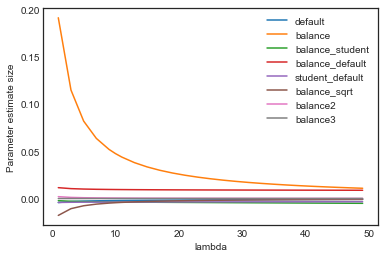

In [11]:
# Store estimates.
estimates = np.append(ridgeregrBig.coef_, [10])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 50, 2):
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(ridgeregrBig.coef_,[lambd])))

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')

# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

### How do you read this graph?
Is it, we pick the lambdas where the parameters are the smallest?  What is the advantage of picking smaller or bigger lambdas?

For a truly deep-dive into the math behind ridge regression, check out these lecture slides on [Ridge Regression](http://www.few.vu.nl/~wvanwie/Courses/HighdimensionalDataAnalysis/WNvanWieringen_HDDA_Lecture23_RidgeRegression_20172018.pdf).

# Unit 3.3.3 Lasso Regression

Ridge regression shrinks parameter estimates, but the estimates never reach exactly 0.  **LASSO** (Least Absolute Shrinkage and Selection Operator), on the other hand, is a model optimization mechanic that works by trying to **force small parameter estimates to be equal to zero, effectively dropping them from the model.**  This can prevent overfitting, and also works as an **embedded feature selection method.**  Lasso is extremely handy when you are dealing with thousands or hundreds of thousands of predictors and need to optimize processor time, or when you want to arrive at a simpler solution that is easier to interpret.

The cost function to minimize for lasso is _very similar_ to the cost function minimized for ridge. Can you spot the difference?

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p|\beta_j| $$

The difference is that rather than penalizing by the sum of *squared* coefficients as ridge does, lasso penalizes by the sum of the ***absolute values* of the coefficients.**  This means the penalty doesn't increase as swiftly with coefficient size.  Regularization based on the sum of the absolute weights is also called "**L1 regularization**".

Why would penalizing with the sum of the absolute values of coefficients lead to a solution with zero estimates for some parameters, while penalizing with the sum of the squares of coefficients does not?  It all comes down to derivatives.

We encountered derivatives briefly during an earlier assignment on the gradient descent algorithm.  You may recall that a partial derivative represents the sensitivity of one quantity to changes in another quantity.  In the case of both ordinary least squares regression and ridge regression, the derivative used to find the optimal solution is the partial derivative of the cost function relative to the coefficients in $\beta$:

$$\frac{\partial}{\partial\beta}$$

Unfortunately, that won't work for lasso. While we can calculate a derivative for most of the values of $x$ in lasso, there is no derivative where $x=0$.  You can imagine this as our multi-dimensional surface made up of gradients having a big hole in it (the technical term for the hole is a "*discontinuity*"). If the gradient descent algorithm calculates a value that falls in the "hole", it has no idea where to go next.  The model "fails to converge". In other words, it fails to arrive at an optimal solution.

^^ **I don't understand this...**

# Fitting Lasso: Coordinate Descent Algorithm

Since basing modeling strategy on a surface with a hole in it is obviously not ideal, lasso regression models are optimized using a **coordinate descent algorithm** rather than a gradient descent algorithm.  Coordinate descent works like this:

Pick some starting values for $\beta$, often $\beta=0$. 

For each feature $j$ in $\beta$:
* Predict the outcome using all features except for $j$.  
* Look at how the residuals from the model using $\beta_{-j}$ (all betas except $j$) correlate with feature $j$. This correlation is called $\rho_j$.  
* If the correlation falls within an area enclosing 0 defined by $\lambda$, set $\beta_j=0$. (called *soft threshholding*)
* If $\rho_j < \frac{\lambda}2$ set $\beta_j$ equal to $\rho_j + \frac{\lambda}2$
* If $\rho_j > \frac{\lambda}2$ set $\beta_j$ equal to $\rho_j - \frac{\lambda}2$

This will iterate through all features 1 through $j$ on each cycle, then begin again.  Alternatively, the algorithm can be set to choose to exclude a feature at random each iteration, rather than cycling through all features.  Each time a feature is checked, it will shrink a bit from the previous time (unless the feature is already set to 0, in which case it will remain 0).

Continue until the maximum difference between parameter estimates in the previous cycle and the current cycle is less than a pre-determined threshold $tol$.  For SKlearn, $tol$ defaults to 0.0001.

**To summarize:** Lasso works by iteratively fitting a model to the data while excluding one of the features.  It then checks how well the model reproduces the data, and if the model fit is good enough (with "good enough" determined by $\lambda$) then the excluded feature is deemed unnecessary and its $\beta$ is set to zero, effectively excluding it from the model. Otherwise, the excluded feature's $\beta$ is set using a combination of the correlation of the feature with the model residuals ($\rho_j$) and $\frac{\lambda}2$ and a new iteration begins, using the newly-computed $\beta$ for the previously-excluded feature and excluding a new feature.  This continues until the change in $\beta$ is less than a pre-determined threshold.

Hopefully this demonstrates how lasso can both create overfitting-protection through shrinkage and create sparsity (many parameters set to 0) through feature selection.  Let's see it at work, using the same dataset as previously.


**Why does Lasso regression use smaller lambdas (alphas)???**

In [12]:
# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)
print('R² for the model with few features:')
print(lass.score(X_train, Y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
print('\nR² for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)

R² for the model with few features:
0.450062579301

Parameter estimates for the model with few features:
[-0.         -0.40657726 -0.          0.00114596]

R² for the model with many features:
0.443633767129

Parameter estimates for the model with many features:
[  0.00000000e+00  -3.89351238e-01   0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00   0.00000000e+00  -2.77688887e-04
  -7.09158792e-07   3.48711577e+00]


Checking predictive power using the test set:

In [13]:
print(lass.score(X_test, Y_test))

print(lassBig.score(X_test2, Y_test))

0.445532251512
0.438046634591


## Regularization parameter: Lasso

The $\lambda$ for lasso can vary between 0 (no penalty, acts like OLS) and infinity.  If $\lambda$ is too large, all parameters will be set to zero.  

Create a plot below of how $R^2$ varies across different values of $\lambda$ for ridge and lasso regression. Use logic and code similar to the ridge regression demonstration above, and base your plot on the X_train2 feature set.

Do lasso and ridge yield the same $R^2$ for a given lambda value?

Submit your work and discuss the results with your mentor.

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


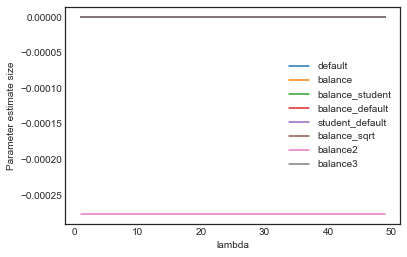

In [14]:
# Store estimates.
estimates = np.append(lassBig.coef_, [10])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 50, 2):
    lassregrBig = linear_model.Lasso(alpha=lambd, fit_intercept=False)
    lassregrBig.fit(X_train2, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(lassBig.coef_,[lambd])))

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')

# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

^^ Did I do this right?

Calculating $R^2$s with different lambdas.

In [41]:
# Store R^2.
lassoBigR2 = np.append(lassBig.score(X_train2, Y_train), [10])
ridgeBigR2 = np.append(ridgeregrBig.score(X_train2, Y_train), [10])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in np.arange(0,50,2):
    lassregrBig = linear_model.Lasso(alpha=lambd, fit_intercept=False)
    lassregrBig.fit(X_train2, Y_train)
    lassoBigR2 = np.row_stack((
        lassoBigR2,
        np.append(lassregrBig.score(X_train2, Y_train),[lambd])))

for lambd in np.arange(0,50,2):
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    ridgeBigR2 = np.row_stack((
        ridgeBigR2,
        np.append(ridgeregrBig.score(X_train2, Y_train),[lambd])))

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel_launcher.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [42]:
ridgeBigR2

array([[  0.57396614,  10.        ],
       [  0.57397331,   0.        ],
       [  0.57396386,   2.        ],
       [  0.573957  ,   4.        ],
       [  0.57395251,   6.        ],
       [  0.57394918,   8.        ],
       [  0.57394643,  10.        ],
       [  0.57394396,  12.        ],
       [  0.5739416 ,  14.        ],
       [  0.57393927,  16.        ],
       [  0.57393689,  18.        ],
       [  0.57393443,  20.        ],
       [  0.57393186,  22.        ],
       [  0.57392916,  24.        ],
       [  0.57392633,  26.        ],
       [  0.57392334,  28.        ],
       [  0.57392019,  30.        ],
       [  0.57391688,  32.        ],
       [  0.5739134 ,  34.        ],
       [  0.57390974,  36.        ],
       [  0.57390592,  38.        ],
       [  0.57390191,  40.        ],
       [  0.57389773,  42.        ],
       [  0.57389337,  44.        ],
       [  0.57388883,  46.        ],
       [  0.5738841 ,  48.        ]])

In [43]:
lassoBigR2

array([[  4.43633767e-01,   1.00000000e+01],
       [  5.73938904e-01,   0.00000000e+00],
       [  4.34046037e-03,   2.00000000e+00],
       [  3.75518950e-03,   4.00000000e+00],
       [  3.16242342e-03,   6.00000000e+00],
       [  2.56239143e-03,   8.00000000e+00],
       [  1.95521310e-03,   1.00000000e+01],
       [  1.34055365e-03,   1.20000000e+01],
       [  7.18413080e-04,   1.40000000e+01],
       [  8.87913979e-05,   1.60000000e+01],
       [ -1.51811140e-05,   1.80000000e+01],
       [ -1.51811901e-05,   2.00000000e+01],
       [ -1.51812743e-05,   2.20000000e+01],
       [ -1.51813664e-05,   2.40000000e+01],
       [ -1.51814666e-05,   2.60000000e+01],
       [ -1.51815748e-05,   2.80000000e+01],
       [ -1.51816910e-05,   3.00000000e+01],
       [ -1.51818152e-05,   3.20000000e+01],
       [ -1.51819474e-05,   3.40000000e+01],
       [ -1.51820877e-05,   3.60000000e+01],
       [ -1.51822359e-05,   3.80000000e+01],
       [ -1.51823922e-05,   4.00000000e+01],
       [ -

Ridge regression does better than lasso when lambda is set between 0 and 50.


(Why though?  And what does mean for the analysis?)